### IMPORT PACKAGES

In [1]:
# Basic Data Processing Packages
from IPython.display import Image, display, HTML
import pandas as pd
import numpy as np
import re

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import base64
from io import BytesIO

# Sklearn Packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.metrics import (calinski_harabasz_score,
                             davies_bouldin_score,
                             silhouette_score)

import warnings
warnings.filterwarnings('ignore', module='seaborn')

# Web Interaction and Display
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/
jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

### DEFINE FUNCTIONS

In [2]:
def plot_internal(ax, inertias, chs, scs, dbs):
    """Plot internal validation values"""
    ks = np.arange(2, len(inertias) + 2)
    ax.plot(ks, inertias, "-o", label="SSE")
    ax.plot(ks, chs, "-ro", label="CH")
    ax.set_xlabel("$k$")
    ax.set_ylabel("SSE/CH")
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.plot(ks, scs, "-ko", label="Silhouette coefficient")
    ax2.plot(ks, dbs, "-gs", label="DB")
    ax2.set_ylabel("Silhouette/DB")
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    ax.set_title('Internal Validation Metrics for k-clusters')
    ax.set_xticks(range(2, 21, 4))
    return ax


def create_vector(dataframe, stop_words, min_df=0.05, max_df=None):
    """Vectorize the dataframe using TfidfVectorizer

    Parameters
    ----------
    dataframe: pandas.DataFrame
        Dataframe that contains Review_Text column for vectorization
    stop_words: list
        List that contains strings not to be included in the vectorization
    min_df: float
        Minimum document frequency for a word to be included
    max_df: float
        Maximum document frequency for a word to be included

    Returns
    -------
    vectorizer: TfidfVectorizer
        TfidfVectorizer used on the text data
    X: sparse matrix
        Matrix that contains the vectorized text data
    """
    vectorizer = TfidfVectorizer(min_df=0.05,
                                 token_pattern=r"\b[a-zA-Z'-]+\b",
                                 stop_words=stop_words)
    X = vectorizer.fit_transform(dataframe['Review_Text'])
    return vectorizer, X


def kmeans_clustering(X, n_cluster=10):
    """Perform KMeans clusterin on the dataset

    Parameters
    ----------
    X: array-like
        Contains the data to be clustered
    n_cluster: int
        The number of clusters to be used in KMeans

    Returns
    -------
    clusterer: KMeans
        KMeans clusterer object used in clustering
    prediction: numpy.array
        Array that contains cluster labels for the dataset
    """
    kmeans = KMeans(n_clusters=n_cluster, random_state=69, n_init="auto")
    predictions = kmeans.fit_predict(X)
    return kmeans, predictions


def cluster_range(X, kmeans, k_start, k_stop):
    """Cluster X for different values of k

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a data point
    clusterer : sklearn.base.ClusterMixin
        Perform clustering for different value of `k` using this model. It
        should have been initialized with the desired parameters
    k_start : int
        Perform k-means starting from this value of `k`
    k_stop : int
        Perform k-means up to this value of `k` (inclusive)

    Returns
    -------
    dict
        The value of each key is a list with elements corresponding to the
        value at `k`. The keys are:
            * `ys`: cluster labels
            * `centers`: cluster centroids
            * `inertias`: sum of squared distances to the cluster centroid
            * `chs`: Calinski-Harabasz indices
            * `scs`: silhouette coefficients
            * `dbs`: Davis-Bouldin indices
    """
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    dbs = []
    for k in range(k_start, k_stop + 1):
        clusterer_k = clone(kmeans).set_params(n_clusters=k)
        clusterer_k.fit(X)
        ys.append(clusterer_k.labels_)
        centers.append(clusterer_k.cluster_centers_)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, clusterer_k.labels_))
        scs.append(silhouette_score(X, clusterer_k.labels_))
        dbs.append(davies_bouldin_score(X, clusterer_k.labels_))

    return {'ys': ys,
            'centers': centers,
            'inertias': inertias,
            'chs': chs,
            'scs': scs,
            'dbs': dbs}


def plot_clusters(X, predictions):
    """Create a scatter plot showing the clusters of the dataset

    Parameters
    ----------
    X: array_like
        Array that contains the vectorized data
    predictions: numpy.array
        Array that contains the cluster labels for the dataset
    """
    svd = TruncatedSVD(n_components=2, random_state=69)
    data_svd = svd.fit_transform(X)
    plt.scatter(data_svd[:, 0], data_svd[:, 1], c=predictions)
    plt.xlabel('SV1')
    plt.ylabel('SV2')
    plt.title('2D Scatter Plot of Dataset w/ Hues per Cluster')


def get_top_words(vectorizer, kmeans):
    """Return a DataFrame that contains the top words of each cluster
    
    Parameters
    ----------
    vectorizer: TfidfVectorizer
        Vectorizer class used in transforming the bag of words
    kmeans: KMeans
        Kmeans clustering class used in clustering the dataset
    
    Returns
    -------
    top_words: pandas.DataFrame
        Contains top words per cluster
    """
    top_words = pd.DataFrame()
    terms = vectorizer.get_feature_names_out()
    n_clusters = kmeans.cluster_centers_.shape[0]
    for n in range(n_clusters):
        center = kmeans.cluster_centers_[n]
        sorted_idx = np.argsort(center)[::-1][:10]
        top_terms = [terms[idx] for idx in sorted_idx]
        top_words['Cluster_' + str(n+1)] = top_terms
    return top_words


def barplot_cluster(df):
    """Return a grouped bar chart that shows percentage of review type per
    Disneyland branch
    
    Parameters
    ----------
    df: pandas.DataFrame
        Contains the review dataset with the cluster labels
    """
    grouped = (df.groupby('Branch')['Cluster']
                 .value_counts()
                 .rename('counts')
                 .reset_index())
    totals = df['Branch'].value_counts().rename('total')
    grouped['Percentage of Reviews'] = grouped.apply(
        lambda x: (x['counts'] / totals[x['Branch']]) * 100, axis=1)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped,
                x='Branch',
                y='Percentage of Reviews',
                hue='Cluster',
                orient='v',
                palette='Spectral')
    plt.title('Percentage of Review Type per Branch')


def plot_to_html(alt_text):
    """Display the current figure as a centered html image
    
    Parameters
    ----------
    alt_text: str
        The alternative text for the image displayed
    """
    fig = plt.gcf()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    fig = base64.b64encode(buf.getvalue()).decode('utf-8')
    html = f'''<div style="text-align: center;">
                   <img src="data:image/png;base64,{fig}"
                        alt="{alt_text}"/>
                   </div>'''
    display(HTML(html))

![Cover Photo](Cover.png)

## ![ABSTRACT](Abstract.png)

The study focuses on the application of clustering techniques to analyze bag-of-words data derived from Disneyland guest feedback, highlighting the challenges and strategies in handling such data for meaningful insights. The research underscores the importance of a meticulous approach in text data vectorization, including the selection of stop words and the adjustment of minimum and maximum document frequencies, emphasizing that these decisions require a tailored, iterative process to identify words relevant to the specific business context.  
<br>
KMeans clustering was used in this study due to its computational simplicity, which allows quick run times for datasets of this size. Despite facing limitations in internal validation metrics, the study successfully identifies expected themes within the feedback, demonstrating that the utility of clustering extends beyond conventional metrics to offer valuable business insights. Through iterative refinement of parameters and a focus on business value, the research reveals underlying guest experience trends, providing Disneyland management with a nuanced understanding of guest feedback that may otherwise be overshadowed by predominant positive ratings.  
<br>
Clustering revealed top strengths such as good customer service, good food, an efficient fast pass system, and great attractions, among others. For areas of concern, the main issue, as expected, is the queuing time for rides and attractions. Other sentiments include rude staff and cast members, expensive price points, closed attractions, and small facilities. Additionally, an interesting insight that the analysis revealed is that each branch has different areas of concern to prioritize. For example, Hong Kong Disneyland seems to fail in meeting guest expectations regarding the size of their amusement park. Disneyland Paris, on the other hand, struggles with poor customer service. California, on the other hand, has some issues with its Fast Pass implementation.  
<br>
This analysis not only aids in identifying less obvious areas for improvement but also enriches the strategic decision-making process by offering a broader perspective on guest satisfaction. Recommendations based on the insights gathered can help Disneyland improve customer experience, which in turn, can translate into increased revenue.

## ![INTRODUCTION](Introduction.png)

![BACKGROUND](Background.png)

Disneyland represents the theme park division of Disney Studios, heralded as "The Happiest Place on Earth." Situated in Anaheim, California, this trailblazing theme park opened its gates on July 17, 1955, marking the inception of the first Disney theme park. It has since evolved into a cherished global symbol, enchanting millions of visitors worldwide with its magical combination of entertainment, attractions, and experiences.  
  
The idea for Disneyland was conceived by Walt Disney during the 1930s and 1940s. Disney envisioned a place where children and their families could immerse themselves in vibrant storytelling and attractions, a stark contrast to the amusement parks of the time, which he found lacking in cleanliness and imagination. After securing financing and purchasing 160 acres of orange groves in Anaheim, construction began in 1954, leading to the park's grand opening in 1955.
  
The success of Disneyland inspired the creation of Disney theme parks worldwide which adapts the original Disneyland concept to fit its cultural context, offering unique attractions and experiences. Establishments include:

- Walt Disney World Resort in Florida
- Tokyo Disneyland
- Disneyland Paris
- Hong Kong Disneyland
- Shanghai Disney Resort  

This study will be limited to <i>Disneyland</i> branches only, that is: Disneylan California, Disneyland Paris, and Hongkong Disneyland.
<br>

![PROBLEM STATEMENT](Problem.png)

On May 21, a romantic moment at Disneyland Paris turned unexpectedly sour when a Disney employee interrupted a couple's marriage proposal. The man, ready to propose to his girlfriend, knelt in front of the iconic Sleeping Beauty Castle, a spot many deem perfect for such a memorable occasion. However, as he was about to pop the question, a Disney staff member intervened. The employee not only stopped the proposal but also snatched the engagement ring from the man's hand, ostensibly enforcing park rules. This abrupt intervention was captured on video and quickly went viral, sparking widespread criticism online (Albeck-Ripka, 2024). This incident led to people online saying that Disney is not the happiest place on Earth anymore.

Amusement parks market size was valued at USD 63.9 billion in 2022 and is estimated to register a CAGR of over 5.5% between 2023 and 2032. Increasing urbanization contributes to the industry gains as more people migrate to urban areas, seeking recreational activities and entertainment options. (Amusement Parks Market Size - Global Forecast, 2023). This is a massive opportunity for Disneyworld to capitalize on. However, this growth is open to all its competitors such as Universal Studios, Legoland, themed parks such as Wizarding World of Harry Potter.
<br>
<br>
<div style="text-align: center;">
  <img src="Chart1.png" alt="Growth Rate Forecast" style="margin: auto; display: block;">
</div>
<br>
<center><b>Figure 1</b>. Forecast on Amusement Parks Market Size in the US.</center>  
<br>
In recent years, post pandemic, there has been a general sentiment of disappointment on Disneyland Parks. People online share their sentiments on issues such as customer service, ride breakdowns, and even fellow guest behavior. The term 'revenge trave' has been coined post pandemic that symbolizes people's desire to travel and entertain themselves after being locked down during the pandemic, this is another great opportunity to capitalize on, but management should not be complacent with quality of service given this demand.
<br>
<br>
The problem now is how Disneyland management would overcome it's current issues, as narrated by customer feedback, in order to maximize growth, retain and entice new visitors to come every year.

![OBJECTIVES](Objective.png)

The primary aim of this study is to harness the power of text data clustering to analyze a large corpus of Disneyland reviews. Through the application of  data science techniques, this study seeks to unearth patterns, themes, and insights that lie hidden within the textual feedback provided by visitors. The objectives of this study are manifold and are outlined as follows:

**1. Understand Visitor Sentiments:**  
Employ clustering methods to categorize reviews into distinct groups based on sentiment, identifying overarching feelings towards various aspects of the Disneyland experience, such as attractions, services, and overall satisfaction.  
  
**2. To Identify Key Themes and Topics:**  
Utilize the bag-of-words model and other text analysis techniques to discover the most frequently discussed topics in reviews. This will help pinpoint areas of strength and opportunities for improvement within the park's operations and visitor experience.

**3. To Inform Operational and Strategic Decisions:**  
Provide data-driven recommendations to Disneyland management on how to optimize operations, improve services, and tailor marketing strategies based on the insights gained from the clustering analysis.  
  
**4. To Enhance Guest Experience:**
By analyzing the clusters and the sentiments associated with them, derive actionable insights that can be used to enhance the overall guest experience at Disneyland. This includes identifying specific areas that elicit positive feedback, as well as addressing concerns or negative perceptions.  
  
**5. Perform Comparison on Different Branches:**  
This objective aims to identify unique characteristics, visitor perceptions, and satisfaction levels specific to each branch.  
  
**6. To Demonstrate the Application of Text Data Clustering:** 
Showcase the utility and versatility of text data clustering techniques in extracting meaningful information from unstructured data, thereby contributing to the broader field of data science and analytics.

# ![THE DATASET](Dataset.png)

![DATA DESCRIPTION](Data_Description.png)

This dataset was imported from Jojie's Public Data Repository. The dataset is named <i>disneyland-reviews</i>. **Table 1** shows the features, corresponding to the columns of the csv file.  
  
| Feature            | Type           | <center>Description</center>                            |
|:------------------:|:--------------:|:--------------------------------------------------------|
| Review_ID          | integer        | Identification number of the review.                    |
| Rating             | integer        | Numerical rating of the review (from 1-5)               |
| Year_Month         | string         | Year and Month of the review submission yyyy-mm format  |
| Reviewer Location  | string         | Country of origin of the reviewer                       |
| Review_Text        | string         | Text that contains the review                           |
| Branch             | string         | Disneyland Branch which is the subject of the review    |

<center><b>Table 1. </b> Disneyland Review Dataset Features</center>

![EDA](EDA.png)

Before conducting any analysis or applying any data science algorithm, data exploration was performed to get an initial outlook on what the data is telling us. Exploratory Data Analysis was performed to answer the following questions:

1. How large is the dataset?
2. Does the dataset need cleaning?
3. What is the distribution of the ratings per branch, and as a whole?
4. How many reviews are there per branch?
5. Which features should be used for clustering?

### DATA INSPECTION

#### SIZE

In [3]:
# Import the Dataset
df = pd.read_csv('/mnt/data/public/disneyland-reviews/DisneylandReviews.csv',
                 encoding='ISO-8859-1')
print(f'Number of Reviews: {df.shape[0]}')
print(f'Number of Features: {df.shape[1]}')

Number of Reviews: 42656
Number of Features: 6


As shown above, the dataset is relatively large, enough to generate clusters of significant sizes. However, the size of the dataset may also be a disadvantage in terms of computational time.

#### DATA TYPES

In [4]:
df.dtypes

Review_ID             int64
Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
dtype: object

#### NULL VALUES

In [5]:
df.isnull().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


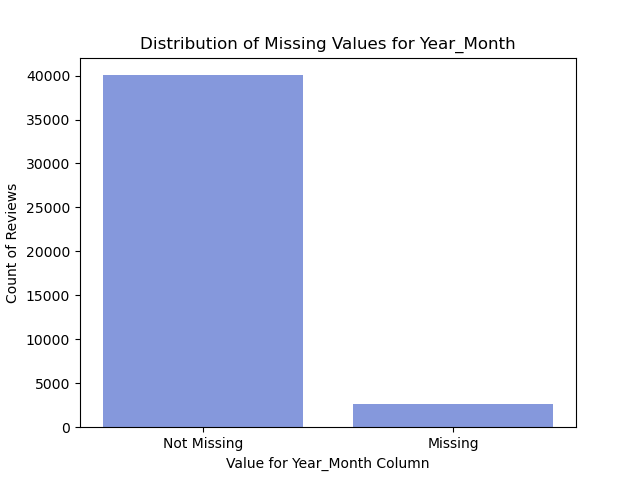

In [6]:
year = df['Year_Month'].value_counts()
year_0 = year.drop('missing')
plt.bar(["Not Missing", "Missing"],
        [year_0.sum(), year['missing']], color='#8598DC')
plt.xlabel('Value for Year_Month Column')
plt.ylabel('Count of Reviews')
plt.title('Distribution of Missing Values for Year_Month')
plot_to_html('Distribution of Missing Values for Year_Month')

<center><b>Figure 2.</b> Disneyland Review Dataset Features</center>  
<br>
<b>Figure 2</b> shows a bar chart that highlights the discrepancy in data availability for <i>Year_Month</i> in a dataset, showing a substantial number of records missing this information. Given the relatively high volume of missing <i>Year_Month</i> data and the fact that this type feature is not something that is typically imputed, this variable is excluded from further analysis.

### DATA EXPLORATION


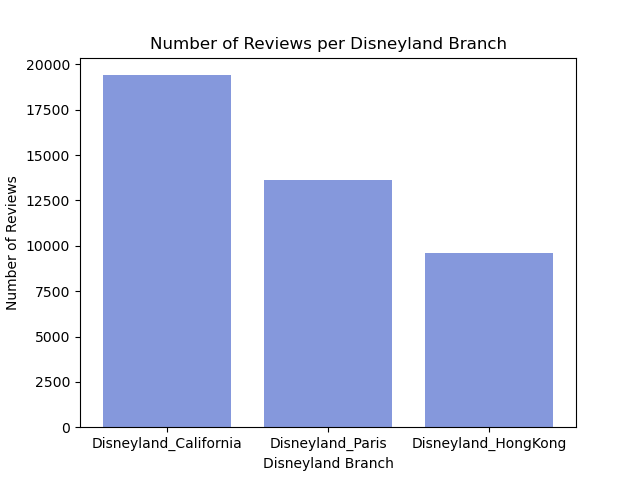

In [7]:
branch = df.Branch.value_counts()
plt.bar(branch.index, branch.values, color='#8598DC')
plt.title('Number of Reviews per Disneyland Branch')
plt.ylabel('Number of Reviews')
plt.xlabel('Disneyland Branch')
plot_to_html('Number of Reviews per Branch')

<center><b>Figure 3.</b> Disneyland Review Dataset Features</center>  
<br>
<b>Figure 3</b> shows a bar chart that displays the number of reviews for Disneyland branches in California, Paris, and Hong Kong. Disneyland California has the most reviews, with almost 19,406. Disneyland Paris follows with a lower count, around 13,630 reviews. Disneyland Hong Kong has the fewest, with approximately 9,620 reviews. This suggests varying levels of visitors and review activity across these Disneyland locations.


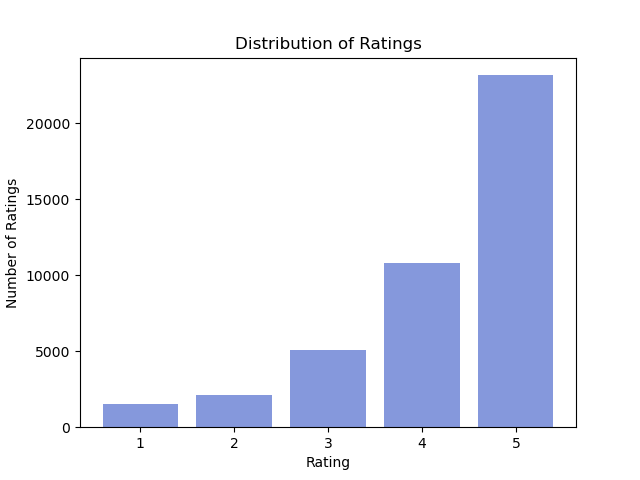

In [8]:
rating = df.Rating.value_counts()
plt.bar(rating.index, rating.values, color='#8598DC')
plt.title('Distribution of Ratings')
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plot_to_html('Distribution of Ratings')

<center><b>Figure 4. </b>Distribution of Ratings</center>  
<br>
The bar chart in <b>Figure 4</b> shows that the most common rating is 5, with over 23,146 instances. Ratings decrease in frequency from 4 to 1, with 5 being the most frequent and 1 the least.


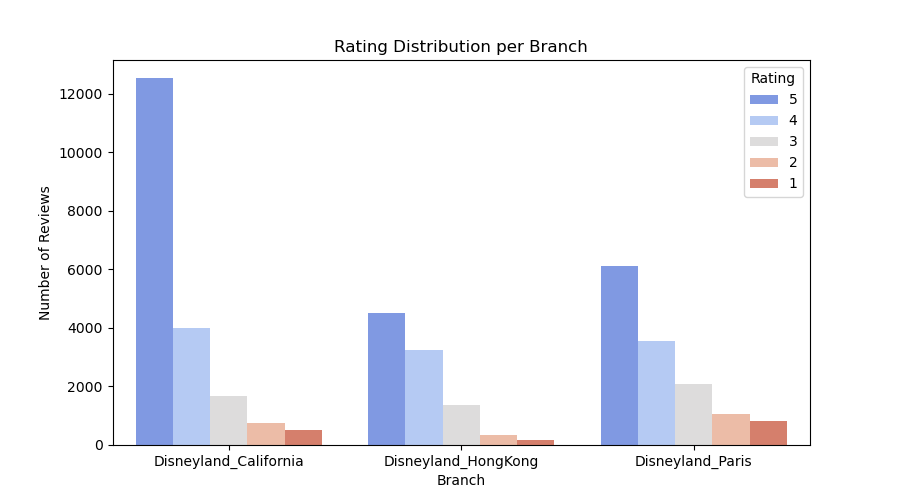

In [9]:
df_copy = df.copy()
df_copy['Rating'] = df_copy['Rating'].apply(str)
grouped = df_copy.groupby('Branch')['Rating'].value_counts().rename(
    'Number of Reviews').reset_index()
plt.figure(figsize=(9, 5))
sns.barplot(data=grouped,
            x='Branch',
            y='Number of Reviews',
            hue='Rating',
            orient='v',
            palette='coolwarm')
plt.title('Rating Distribution per Branch')
plot_to_html('Rating Distribution per Branch')

<center><b>Figure 5. </b> Distribution of Ratings per Disneyland Branch</center>  
<br>
For <b>Figure 5</b> the grouped bar plot shows the distribution of ratings for the three Disneyland branches. California leads with the highest number of 5-star reviews, while Hong Kong's reviews are more evenly spread across ratings 2 to 5. Paris, like California, sees a majority of 5-star ratings. The trend indicates a higher proportion of high ratings for California then Paris and lastly, Hongkong.

![METHODOLOGY](Methodology.png)

![METHODOLOGY FLOWCHART](Method.png)

<center><b>Figure 6.</b> Workflow Methodology</center>

**Figure 6** above shows the methodology that is going to be used in the study. It enumerates the necesssary steps to arrive at the desired output, which is the business insights that can be offered to Disneyland management. The Methodology includes the following steps:  
  
1. **SPLIT THE DATA** - the first step was to split the reviews into positive and negative. A simple exploration in the dataset would reveal that majority of the positive reviews are reviews with a rating of 4 or 5, while negative reviews correspond to ratings 1,2, and 3. However, one caveat is that for reviews of ratings 1 to 3, they usually contain both positive and negative feedback. To avoid positive clusters from forming in the 1-3 Rated reviews, stop words were customized.
<br>
<br>
2. **VECTORIZATION** - vectorization is usually the first step of any bag words analysis. This facilitates the conversion of text data into a numerical array or matrix. The use of Tfidf Normalization is desirable for bag of words analysis because it emphasizes the information gain from uncommon words, rather than common words that are in most of the reviews. Parameters such as stop words and minimum document frequency was used in vectorization. Max document frequency was not used, since the comprehensive stop words list was enough to weed out common words throughout the reviews.  
<br>
<br>
3. **CLUSTERING** - clustering would allow the grouping of reviews into similar themes or sentiments. For clustering, KMeans was used for this study. To determine the ideal number of clusters, internal validation metrics were also calculated such as <i>SSE, Silhouette Coefficient, Calisnki-Harabas Score, and Davies-Bouldin Index</i>. Gap statistic was not utilized for this case due to computational requirements. KMeans clustering was used in this analysis for several reasons:
    - The computational cost for agglomerative clustering for 40,000 document bag of words was too high. The machine the code was run on could not handle the workload and the computation kernel kept on failing. Although Ward's linkage agglomerative clustering would have been great in this use case since we expect some level of heteroskedasticity due to an imbalanced number of positive and negative reviews.
    - Density based scanning is rarely appropriate for bag of words analysis, since bag of words data is usually sparse and noisy. The results for OPTICS can be seen on the supplemental notebook and the clusters formed is not ideal for this use case.
<br>
<br>
4. **DEFINE THE CLUSTERS** - after performing KMeans clustering, the next step is to interpret and define the clusters. The approach this study used is to extract the centroids of the clusters and get the top 10 words of each. The top 10 words of the cluster centroid will then be used to infer context from the cluster. The goal is to assign a particual area of strength or weakness for each cluster. Since bag of words analysis only detects word frequency and not context, it is possible that different clusters might allude to the same topic. This is the result of using different words with the same meaning, for example two clusters might be formed from top words such as lines and queues. Even if they mean the same, a simple bag of words analysis will always differentiate them.
<br>
<br>
5. **CLUSTER INSIGHTS** - the final step is to perform exploratory data analysis on the clustered data. By comparing prominent clusters for each Disneyland branch we can identify their strengths and weaknesses and make recommendations for each branch based on the results.
<br>
<br>
<b>ITERATIVE STEPS:</b>
<br>
- <u>REDEFINE TFIDF VECTORIZATION PARAMETERS</u>: A usual problem for bag of words analysis in general is that, some words which are not valuable to the use case can be emphasized due to it's sheer frequency. Few iterations in this study resulted in clusters where the top words were common words such as <i> able, went, day, year </i> this can be remedied by adjusting document frequency parameters such as min_df and max_df, or a more direct approach would be to customize stop words. For negative reviews, positive stop words was used to prevent positive clusters from forming. This focuses the clustering on the negative aspect of the feedback which is more valuable in this use case.  
    
- <u>CHANGE CLUSTERING PARAMETERS</u>: One weakness of KMeans clustering is that, iteration is needed to experiment with different $k$- clusters. Multiple iterations might be needed to achieve the optimal clustering result, changing the n_cluster parameter each time.  
<br>
<b>DIMENSIONALITY REDUCTION:</b>
<br>
Dimensionality reduction is a common step that is utilized in any data science application. It has the ability to simplify the calculation by reducing the amount of features to analyze. For this study, the final iteration does not involve dimensionality reduction for the following reasons:<br>
<br>
- A trial of KMeans clustering on data reduced via SVD showed better internal validation metrics, but worse in terms of cluster definition. The clusters that were formed were not valuable to the business problem. (Refer to Supplemental Notebook)  
- In lieu of dimensionality reduction, extensive tuning of TfidfVectorization was performed to reduce the size of the corpus. It was more intuitive to focus on refining the vectorization parameters, because it is easy to iterate on and the thought process on parameter tuning is easy to understand.  
- Dimensionality reduction always has a tradeoff of loss of information. Since the result of non transformed data was satisfactory, it was logical to retain all of the information by opting to not reduce the dimensions.

![CLUSTERING](Clustering.png)

In [10]:
# Split the Data
df_pos = df[(df.Rating == 4) | (df.Rating == 5)].copy()
df_neg = df[(df.Rating == 1) | (df.Rating == 2) | (df.Rating == 3)].copy()

### POSITIVE REVIEWS

In [11]:
addl_stop_words = {'hongkong', 'hong', 'kong', 'paris', 'california', 'disney',
                   'disneyland', 'florida', 'hk', "it's", 't', 's'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(addl_stop_words))


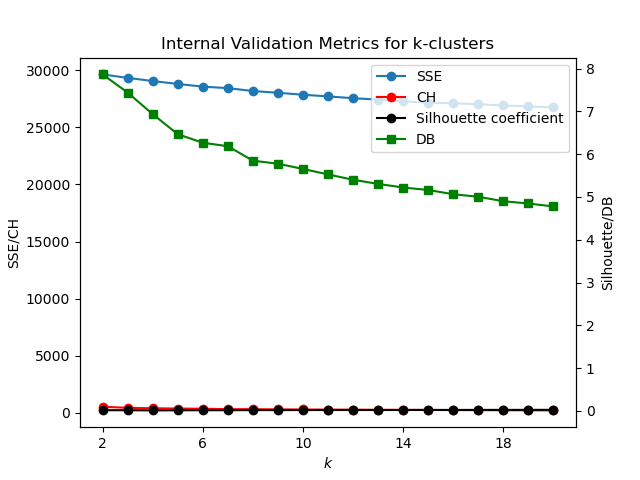

In [12]:
vectorizer_pos, X_pos = create_vector(df_pos, stop_words, min_df=0.05)
res_pos = cluster_range(X_pos.toarray(), KMeans(
    random_state=69, n_init='auto'), 2, 20)
fig, ax = plt.subplots()
plot_internal(
    ax,
    res_pos["inertias"],
    res_pos["chs"],
    res_pos["scs"],
    res_pos["dbs"],
)
plot_to_html('Internal Validation Metrics Plot')

<center><b>Figure 7.</b> Plot of Internal Validation Metric Scores fore each k-cluster</center></center>
<br>
The graph shown in <b>Figure 7</b> implies that $k$-means clustering for positive reviews suggests no clear optimal k value. SSE declines with more clusters, CH is flat, and silhouette scores are consistently low. The DB index decreases, suggesting some separation improvement. A potential balance might be at k=10, where SSE's decline slows, and the DB index is relatively low, though clusters may still lack clear definition.  
<br>
<br>
Given this scenario, we decided to iterate starting from the most granular clusters $k = 20$ and decreasing it until we get the ideal clustering result. What we want is to capture as much themes as possible with a minimal number of clusters. Iteration stops when a decrease in the number of clusters, resulted in a particular theme disappearing and merging with another.


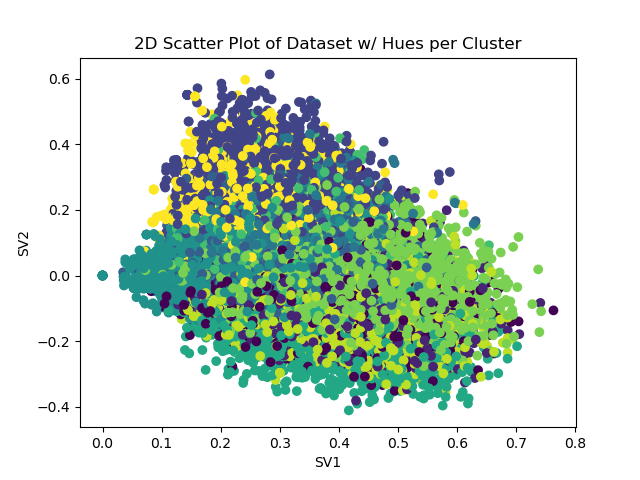

In [13]:
kmeans_pos, predict_pos = kmeans_clustering(X_pos, n_cluster=11)
df_pos['Cluster'] = predict_pos
plot_clusters(X_pos, predict_pos)
plot_to_html('Scatter Plot Positive Reviews')

<center><b>Figure 8.</b> Scatter Plot of Positive Reviews on Two SVD Vectors with cluster color assignment</center>

One weakness of KMeans clustering is that the results cannot be easily visualized, specially if there is high dimensionality in the dataset. **Figure 8** shows the clustering on 2 dimensions of SVD transformed axes, but again since this only shows 2 dimensions it is difficult to estimate the quality of the clustering. Exploratory Data Analysis will prove to be the better method in gauging the quality of our clusters.

### NEGATIVE REVIEWS

Same procedure as for positive reviews.


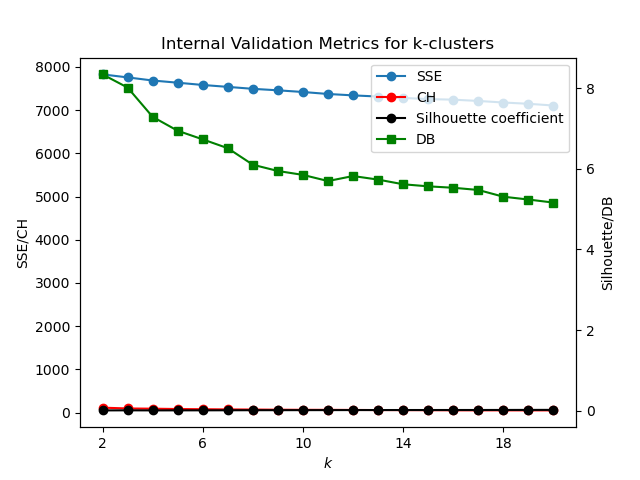

In [14]:
# Define Stop Words
addl_stop_words = {'hongkong', 'hong', 'kong', 'paris', 'california', 'disney',
                   'disneyland', 'florida', 'hk', "it's", 't', 's', 'day',
                   'good', 'fun', 'great', 'like', 'love', 'visit', 'kids',
                   'children', 'adults', 'really', 'just', 'park', 'parks',
                   'ride', 'rides'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(addl_stop_words))

# Perform TfidfVectorization
vectorizer_neg, X_neg = create_vector(df_neg, stop_words, min_df=0.05)

# Calculate Internal Validation Metrics for each k
res_neg = cluster_range(X_neg.toarray(),
                        KMeans(random_state=69, n_init="auto"),
                        2, 20)

# Plot the results
fig, ax = plt.subplots()
plot_internal(
    ax,
    res_neg["inertias"],
    res_neg["chs"],
    res_neg["scs"],
    res_neg["dbs"],
)

plot_to_html('Internal Validation Metrics Plot')

<center><b>Figure 9.</b> Plot of Internal Validation Metric Scores fore each k-cluster</center></center>
<br>
The graph on <b>Figure 9</b> shows the internal validation metrics for negative reviews is the same for positive reviews, therefore the same methods was employed for negative reviews.

In [15]:
addl_stop_words = {'hongkong', 'hong', 'kong', 'paris', 'california', 'disney',
                   'disneyland', 'florida', 'hk', "it's", 't', 's', 'day',
                   'good', 'fun', 'great', 'like', 'love', 'visit', 'kids',
                   'children', 'adults', 'really', 'just', 'park', 'parks',
                   'ride', 'rides'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(addl_stop_words))

vectorizer_neg, X_neg = create_vector(df_neg, stop_words, min_df=0.05)
res_neg = cluster_range(X_neg.toarray(),
                        KMeans(random_state=69, n_init="auto"),
                        2, 20)


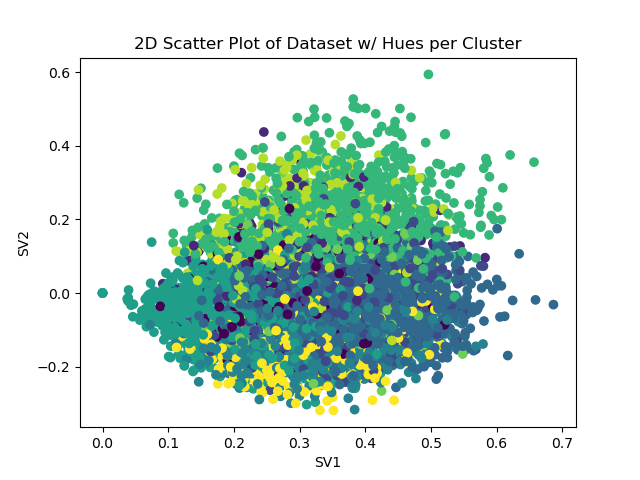

In [16]:
kmeans_neg, predict_neg = kmeans_clustering(X_neg, n_cluster=10)
df_neg['Cluster'] = predict_neg
plot_clusters(X_neg, predict_neg)
plot_to_html('Scatter Plot Negative Reviews')

<center><b>Figure 10.</b> Scatter Plot of Negative Reviews on Two SVD Vectors with cluster color assignment</center><center><b>

### DEFINING THE CLUSTERS

In [17]:
get_top_words(vectorizer_pos, kmeans_pos);

<b><i>POSITIVE REVIEWS</i></b>  
| Rank | Cluster_1	| Cluster_2	| Cluster_3	| Cluster_4	| Cluster_5	| Cluster_6	| Cluster_7	| Cluster_8	| Cluster_9	| Cluster_10 | Cluster_11 |
|:----:|:----------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:----------:|:----------:|
|1	   |mountain	|day	    |place	    |staff	    |great	    |time	    |fast	    |fun	    |food	    |park	     | love       |
|2	   |space	    |park	    |visit	    |friendly	|time	    |rides	    |pass	    |rides	    |good	    |rides	     | place      |
|3	   |ride	    |rides	    |kids	    |helpful	|rides	    |loved	    |rides	    |kids	    |rides	    |time	     | time       |
|4	   |rides	    |time	    |magical    |park	    |park	    |year	    |passes	    |time	    |park	    |visit	     | park       |
|5	   |park	    |went	    |great	    |clean	    |kids	    |visit	    |time	    |great	    |time	    |day	     | rides      |
|6	   |time	    |just	    |rides	    |rides	    |day	    |old	    |park	    |park	    |expensive	|parks	     | kids       |
|7	   |day	        |visit	    |time	    |time	    |food	    |kids	    |ride	    |day	    |really	    |theme	     | just       |
|8	   |big	        |ride	    |family	    |great	    |family	    |experience	|day	    |family	    |kids	    |attractions | great      |
|9	   |pirates	    |great	    |amazing    |amazing	|experience	|world	    |use	    |lots	    |just	    |ride	     | fun        |
|10	   |star	    |did	    |day	    |place	    |visit	    |like	    |wait	    |place	    |hotel	    |world	     | visit      |  
<center><b>Table 2.</b> Top 10 Words per Cluster for Positive Reviews</center>


- **Cluster 1** - <u>Space, Mountain, Rides, Ride</u>
    - Might be referring to great feedback regarding the <i>Space Mountain</i> attraction.
- **Cluster 2** - <u>Day, Park, Rides, Great</u>
    - This is a generic good feedback cluster, talking about how the visitor had a great time.
- **Cluster 3** - <u>Place, Magical, Great, Family, Amazing</u>
    - This cluster groups reviews that echo the magical feeling of being in Disneyland.
- **Cluster 4** - <u>Staff, Friendly, Helpful, Clean</u>
    - Reviews that commend the staff for being friendly and helpful.
- **Cluster 5** - <u>Great, Time, Rides, Park, Family, Visit</u>
    - Positive reviews that narrates how the visitor had a great time with the park and rides.
- **Cluster 6** - <u>Time, Rides, Loved, Experience, Kids, Visit</u>
    - Reviews with an emphasis on how kids enjoyed the rides.
- **Cluster 7** - <u>Fast, Pass, Rides, Time, Use</u>
    - Narrates positive feedback regarding the use of the Fast Pass system.
- **Cluster 8** - <u>Fun, Rides, Kids, Family</u>
    - Another generic cluster on having fun at disneyland with the family and kids.
- **Cluster 9** - <u>Food, Good, Hotel</u>
    - This cluster is all about good food, in the park or at the hotel. It could also be referring to good hotel accomodations itself.
- **Cluster 10** - <u>Park, Rides, Parks, Theme, Attractions</u>
    - The reviews in this cluster revolves around positive feedback on the themes of particular attractions.
- **Cluster 11** - <u>Love, Park, Great, Fun, Visit</u>
    - Another generic positive cluster on how people loved their experience at disneyland.

In [18]:
get_top_words(vectorizer_neg, kmeans_neg);

<b><i>NEGATIVE REVIEWS</i></b>
|Rank |Cluster_1	|Cluster_2	|Cluster_3	 |Cluster_4	 |Cluster_5	 |Cluster_6	    |Cluster_7	|Cluster_8	|Cluster_9	 |Cluster_10    |
|:---:|:-----------:|:---------:|:----------:|:---------:|:---------:|:------------:|:---------:|:---------:|:----------:|:------------:|
|1	  |place	    |crowds	    |queues	     |time	     |staff	     |small	        |line	    |cast	    |lines	     |closed        |
|2	  |people	    |people	    |long	     |queue	     |rude	     |world	        |pass	    |members	|long	     |attractions   |
|3	  |food	        |time	    |food	     |hotel	     |people	 |time	        |fast	    |world	    |time	     |mountain      |
|4	  |time	        |lines	    |queue	     |food	     |friendly	 |food	        |wait	    |time	    |people	     |open          |
|5	  |expensive	|went	    |time	     |old	     |food	     |better	    |time	    |people	    |food	     |time          |
|6	  |crowded	    |times	    |expensive	 |people	 |time	     |attractions	|minutes	|rude	    |attractions |disappointed  |
|7	  |don't	    |crowded    |people	     |year	     |experience |experience	|people	    |magic	    |crowded	 |thunder       |
|8	  |enjoy	    |wait	    |attractions |characters |service	 |expensive	    |waiting	|times	    |line	     |food          | 
|9	  |money	    |long	    |hour	     |went	     |french	 |orlando	    |hours	    |line	    |wait	     |visited       |
|10	  |experience	|don't	    |minutes	 |did	     |magic	     |worth	        |hour	    |don't	    |waiting	 |went          |
<center><b>Table 3.</b> Top 10 Words per Cluster for Negative Reviews</center>

Negative clusters from reviews rated 1-3:
- **Cluster 1** - <u>Food, Time, Expensive, Don't, Enjoy, Money</u>
    - Expensive, not worth the money.
- **Cluster 2** - <u>Crowds, People, Lines, Crowded, Wait, Long</u>
    - Long Lines, Crowded, Wait Time.
- **Cluster 3** - <u>Queue/s, Long, Hour, Minutes, Attractions</u>
    - This cluster could be alluding to long lines to rides and attractions.
- **Cluster 4** - <u>Time, Queue, Hotel, Food</u>
    - This cluster of reviews could be referring to long queues on food and in the hotel.
- **Cluster 5** - <u>Staff, Rude, People, Service</u>
    - Reviews from this cluster is concerned with poor customer service.
- **Cluster 6** - <u>Small, Better, Attractions</u>
    - This cluster might be referring to reviews that compare the specific disneyland as being small compared to another.
- **Cluster 7** - <u>Line, Pass, Fast, Wait, Time, Hours</u>
    - Reviews in this cluster could be referring to long waiting times, and people who use the Fast Pass system getting priority.
- **Cluster 8** - <u>Cast, Members, Rude</u>
    - This cluster of reviews regarding rudeness now refers to Cast Members.
- **Cluster 9** - <u>Lines, Long, Attractions</u>
    - Another cluster alluding to long lines to particular attractions.
- **Cluster 10** - <u>Closed, Rides, Attractions, Disappointed</u>
    - The keywords are most probably referring to experiences where several attractions were closed during the time of visit.
  
  


![ANALYSIS OF RESULTS](Analysis.png)

### FINAL CLUSTERING LABELS

After retrieving the top words for each cluster, and trying to figure out the context of each cluster based on top words, the next step is to define the cluster. We generalize the sentiments in each cluster into a specific theme of interest. Since bag of words analysis cannot take into account the context or meaning of words, we observe that for the results we have clusters that are similar in meaning but different in use of words, one such example is a cluster formed from reviews with the words **"Lines"** and another cluster with the word **"Queues"**. These two words have the same meaning, but a simple bag of words analysis cannot differentiate them. A good workaround for this is to simply combine clusters with the same meaning into one, representing a common theme. **Figure 11** below shows which clusters were merged, and the corresponding themes.

![CLUSTER RESULTS](Clusters.png)

<center><b>Figure 11.</b> Grouping and Final Definition of Clusters</center><center><b>

In [19]:
df_pos_result = df_pos.copy()
df_neg_result = df_neg.copy()
df_pos_result['Type'] = 'Positive'
df_neg_result['Type'] = 'Negative'
pos_mapper = {0: 'Space Mountain',
              1: 'Great Time',
              2: 'Magical Theme',
              3: 'Customer Service',
              4: 'Great Time',
              5: 'Great Time',
              6: 'Fast Pass Advantage',
              7: 'Great Time',
              8: 'Good Food',
              9: 'Themed Attractions',
              10: 'Great Time'}
neg_mapper = {0: 'Expensive',
              1: 'Long Queues',
              2: 'Long Queues',
              3: 'Long Queues',
              4: 'Rude Staff',
              5: 'Small',
              6: 'Fast Pass Priority',
              7: 'Rude Cast',
              8: 'Long Queues',
              9: 'Closed Attractions'}

In [20]:
df_pos_result['Cluster'] = df_pos_result['Cluster'].map(pos_mapper)
df_neg_result['Cluster'] = df_neg_result['Cluster'].map(neg_mapper)

### VALIDATING CLUSTER ASSIGNMENT

In this section, we take a random review from an assigned cluster and check the content if it matches the theme assigned to the cluster.

In [21]:
# POSITIVE CLUSTERS
magical_theme = (df_pos_result[df_pos_result.Cluster == 'Magical Theme']
                 .sample(1, random_state=69)['Review_Text'].iloc[0])
fast_pass = (df_pos_result[df_pos_result.Cluster == 'Fast Pass Advantage']
             .sample(1, random_state=6)['Review_Text'].iloc[0])
customer_service = (df_pos_result[df_pos_result.Cluster == 'Customer Service']
                    .sample(1, random_state=69)['Review_Text'].iloc[0])

# NEGATIVE CLUSTERS
expensive = (df_neg_result[df_neg_result.Cluster == 'Expensive']
             .sample(1, random_state=1)['Review_Text'].iloc[0])
rude_staff = (df_neg_result[df_neg_result.Cluster == 'Rude Staff']
              .sample(1, random_state=69)['Review_Text'].iloc[0])
closed = (df_neg_result[df_neg_result.Cluster == 'Closed Attractions']
          .sample(1, random_state=2)['Review_Text'].iloc[0])

**Positive Clusters**  
- Magical Theme:   
   <u>It's the magical land. What makes Disney so magical is their performers and staff</u>. The are the core of the park and they are the responsible for us to <u>feel in a magical place</u>. Will return many many times to this wonderful place.

- Fast Pass Advantage:    
   My daughter and I had a great day at Disney. We got there when it opened and did most of the rides at least once before it got busy. <u>Would recommend getting fast passes</u> for repeat rides and then enjoying other rides whilst waiting for your fast pass time. Food is expensive and not great. Overall a good day out   we had fun esp as it was Xmas and the decorations were nice. 

- Customer Service:  
    Loved it here. Was alot of fun, the rides were a bit tamer than California Adventure Park. Would definately come back, especially with kids. Kids would love it here! <u>The staff were friendly, we felt very safe on the rides!</u> We spent one a a half days here which was enough to cover all of the rides! Great day!

**Negative Clusters**
- Expensive:  
   Reaching : easy connected via metro  Place : Good for kids only, will be upset if you seen US  <u>Cost : very costly for the time you spend</u>

- Rude Staff:  
   We've been huge Disney fans for over 30 YEARS... cruises, park visits, etc. The service levels we experienced at those venues were always top notch. This was not the case in California Adventure, or Disneyland parks. <u>Staff were not that friendly and some were downright annoyed with us pesky customers. Frankly, we were shocked enough to write to corporate about it. Very disappointing.</u>

- Closed:  
   If this was my first Disney experience it may have been different for me. It is much less expensive than Anaheim or Orlando but it is much smaller with far fewer attractions, <u>many of which were closed</u> when I was there. The gardens are lovely. I am glad I went, but probably won't return.

### EDA ON RESULTS


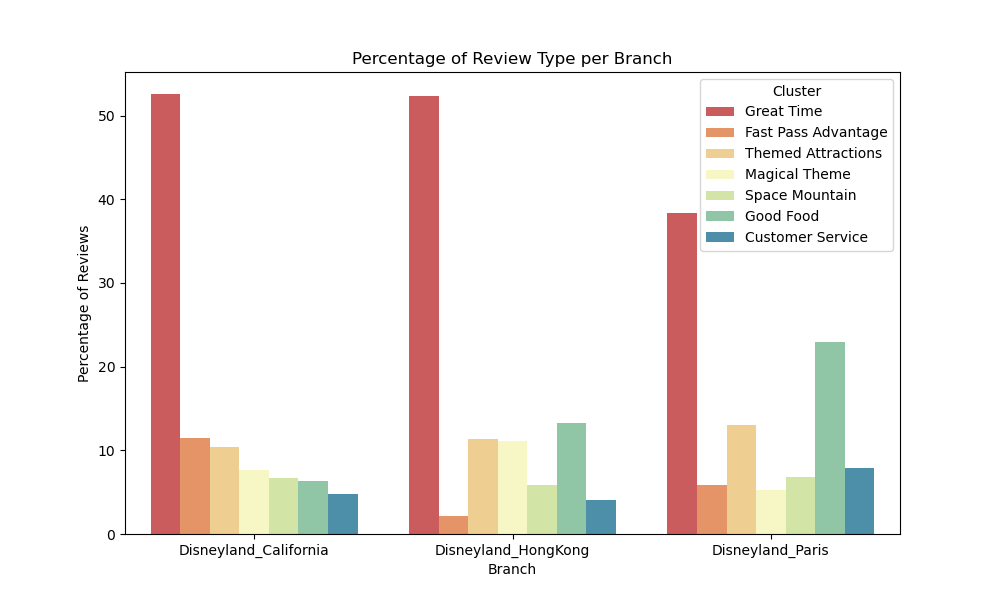

In [22]:
barplot_cluster(df_pos_result)
plot_to_html('Percentage of Positive Review Type per Branch')

<center><b>Figure 12.</b> Distribution of Positive Review Themes for Reviews Rated 4 to 5</center>
<br>
<b>Disneyland California Strengths:</b><br>
- Fast Pass Advantage: it seems that a lot of visitors enjoy the fast pass advantage in Disneyland California.<br><br>
<b>Disneyland Hongkong Strengths:</b><br>
- Magical Theme: Hongkong's unique strength is giving that magical experience to customers, it could be because of the park's design or even the performances, parades or fireworks.<br><br>
<b>Disneyland Paris Strengths:</b><br>
- Good Food: The Paris Branch highlights excellent feedback on it's food offerings, it might be wise for other branches to check on Disneyland Paris' food offerings. Caution should still be taken since they might be catering to different customers.


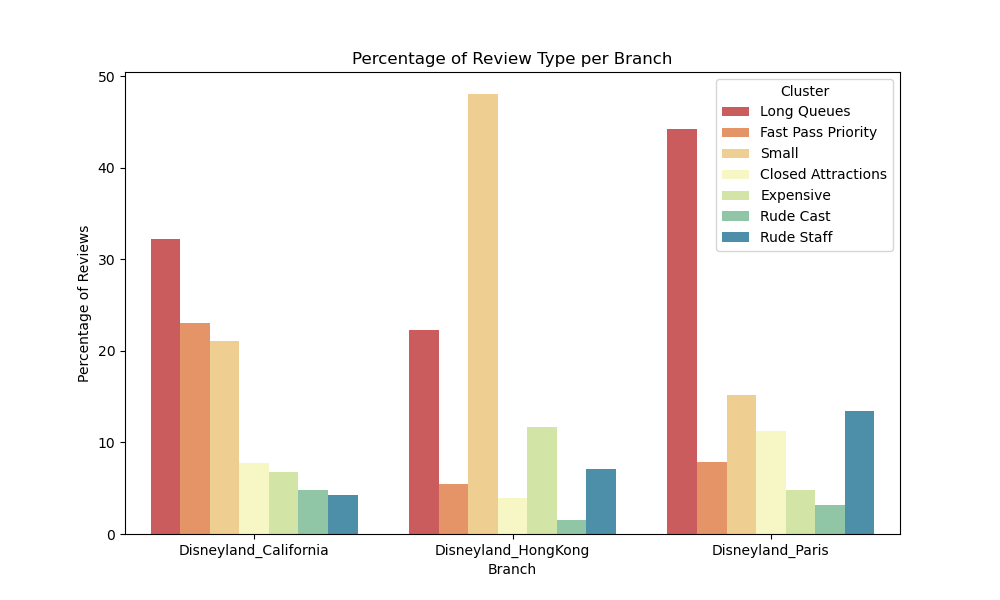

In [23]:
barplot_cluster(df_neg_result)
plot_to_html('Percentage of Negative Review Type per Branch')

<center><b>Figure 13.</b> Distribution of Positive Review Themes for Reviews Rated 1 to 3</center>
<br>
<b>Disneyland California Weakness:</b><br>
- Long Queues: The number one issue for all amusement parks. Nobody wants to pay for tickets just to spend half of their time queueing for attractions.<br>
- Fast Pass Priority: Disneyland California's main strength is also its main weakness. A lot of customers feel that they are taken advantage of. They feel that to truly enjoy Disneyland California they have to pay an additional for the fast pass. A high number of fast pass users could mean that regular visitors take more time to queue for rides.
<br><br>
<b>Disneyland Hongkong Weakness:</b><br>
- Small Park: The main criticism for Disneyland Hongkong is that it is small, perhaps the park does not meet the expectation of visitors, specially those who have been to other Disneyland branches, or even other amusement parks.<br>
- Long Queues: Hongkong experiences the same issues with queueing.<br>
- Expensive: The next issue Disneyland Hongkong needs to tackle is its pricing point. It could be for admission, fast pass, or food. One main issue that could be driving this is the region it serves, it is possible that visitors of this branch are more thrifty than its western counterparts.  
<br><br>
<b>Disneyland Paris Weakness:</b><br>
- Long Queues: The Paris branch has the highest proportion of feedback regarding long queues, this should be carefully looked into since their exceed other branches in comparison by a lot.<br>
- Rude Staff: Poor customer service also seems to be a main issue for Disneyland Paris, perhaps there is a cultural shock for customers since Paris and Europe in general tend to be not customer centric. They might have to train or adjust their service mindeset to overcome this.<br>
- Closed Attractions: The timing of Disneyland Paris' attraction renovations or breakdowns caught the attention of visitors. Visitors could have a sentiment that they are not getting what they paid for due to these closures, specially if the visit seldomly.

### BUSINESS RECOMMENDATIONS

#### Disneyland California

1. <b>Ride Times Optimization:</b><br>
The sheer number of visitors in Disneyland California leads to long queues for attractions. Management may use real-time data to provide queue predictions and predict peak times.<br><br>
2. <b>Manage Fast Pass Limit:</b><br>
Disneyland management should perform a balancing act on the fast pass system. Too much fast pass usage aggravates visitors who do not use them, but foregoing implementation of fast pass deprives the Fast Pass enthusiast of the convenience.
<br><br>
3. <b>Queue Entertainment:</b><br>
Since the problem of long queues is really a capacity, one approach is to make queue a bit less hectic. Management can deploy entertainment near queueing sites such as parades, or cast members that entertain guests that are currently queueing.
<br><br>
4. <b>Improve Queueing Comfort:</b><br>
The least an amusement park could to to appease queueing guests is to make queueing comfortable. There are numerous complaints that expressed discomfort specially when queueing under the sun, simple accomodations such as shades in the form of structures or perhaps more trees could be a good idea. Improved ventilation and seated queues, if feasible, can also be explored.

#### Disneyland Hong Kong

1. <b>Explore Possible Expansions</b><br>
Since the main concern for Disneyland Hong Kong is the size of the amusement park as a whole, an expansion might be a good idea. Although this option is for a long term strategy, and it is highly dependent on feasibility. In the event that it is not possible, the park may opt to improve the quality of attractions instead of prospecting expansion, basically to do and offer more with the limited size of their park.<br>

2. <b>Reconfigure Pricing Strategy</b><br>
The market of Disneyland Hong Kong might be different for its western counterparts, the amount of money their market is willing to spend lower. Disneyland Hongkong could try to re evaluate their pricing models and consider offering seasonal discounts as long as the increase in guests translate to a net increase in profits.

#### Disneyland Paris

1. <b>Improve Fast Pass Marketing</b><br>
Disneyland Paris experiences the worst feedback in terms of long queues. Another observation is that there is not much complaints against the fast pass system and consequently Fast Pass advantage is also not the strength of Disneyland Paris. This means that despite long lines, people still forego the usage of the Fast Pass system. Marketing the Fast Pass better in ways such as increasing awareness and educating guests on how to use it can improve overall customer experience.<br>

2. <b>Additional Staff Training</b><br>
Prominently, guests comment on Disneyland Paris' poor customer service. Management may opt to address the staff of this issue and implement additional trainings on how to effectively treat customers. This can be combined with incentivization if the budget permits, incentivize or penalize staff that are proven to be rude to staff.<br>

3. <b>Maintenance Optimization</b><br>
Disneyland Paris has the highest proportion of reviews alluding to closed attractions. Management should try to reassess the park's maintenance plan to avoid unexpected breakdowns. Implement proper preventive maintenance to make sure that maintenance is done on off peak seasons, or better when the park is closed.

4. <b>Customer Communication</b><br>
Maintenance and refurbishments that results in the temporary closure of attractions can be communicated better to prospect guests. This can allow guests to be flexible in planning their time of visit, specially if they are looking forward to a particular attraction. This can results to better customer experience and consequently better feedback.

#### Fast Pass or Not?

One of the interesting aspects that the results show is how Fast Pass affects customer experience. For context, Fast Pass is a virtual queueing system where a guest can virtually queue on an attraction by scanning their ticket on a kiosk near a ride. This allows them to come back at a scheduled time where they queue up on the Fast Pass lane, which is usually very short, this prevents idle waiting which can end up taking an hour at most.  
<br>
Historically Disneyland California, Paris, and Hong Kong implemented the Fast Pass system and also Max Pass, a paid version that allows the guest to queue via an app instead of going to the kiosk. As of 2021, the Fast Pass system has been retired in favor of Disney Genie for California, and Disney Premier Access for Hong Kong and Paris, both of which are paid versions of the Fast Pass System.  
<br>
Based on the results of the clustering when comparing California and Paris, it seems that the Fast Pass system decreases Long Queues sentiment, but increases negative Fast Pass sentiment, most probably from non Fast Pass users. We can see the opposite for Paris wherein long queues is the main issue but no one seems to be complaining about the fast pass prioritization system. From this analysis it may be inferred that the Fast Pass is effective in improving guest experience by reducing queue times, but for it to become a net positive improvement towards guest sentiment, it should be utilized by majority of the guests. People who might not be aware of it or how to use it might not be so happy seeing the fast pass users get ahead in line.  
<br>
Given this logic, a good direction for Disneyland Management is to educate guests on the advantages of the Fast Pass and how it works. Since, it is an effective system as long as guests utilize it, the next logical thing for Disneyland to do is to offer it as a premium, which is what they did eventually on 2021. However, after this change the management should monitor the feedback of guests who do not avail of the premium pass. The premium fast pass system can then be seen by guests as Disneyland taking advantage of its guests. Continuous evaluation of this new system must be monitored to determine if the new system actually improves net revenue at the cost of negative sentiments from others who do not avail of the premium.

![CONCLUSION](Conclusion.png)

This study showcases the effectiveness of clustering bag of words data from Disneyland guest feedbacks. The study showcases the complexities of handling bag of words and its limitations.  
  
The first aspect which can dictate the results of the analysis is how the text data is vectorized. What are the stop words that should be used? What are the minimum and maximum document frequencies that need to be set? There is no one size fits all heuristic that can dictate how these things are decided, for this study the process really became an iterative process. The researchers should be able to determine which words are relevant and valuable to the business use case. It might also be tempting to maximize the $min_df$ and $max_df$ parameters, however too much can lead to loss of information.  
  
For clustering, figuring out the right clustering method is always the first question that needs to be answered. Factors external to the data such as available computational resources and time constraint can be the deciding factors on which method to choose.  Large Datasets such as this one can limit the choice of clustering algorithms. For internal factors, the nature of the data and the use case will greatly impact the decision. Data attributes such as homoskedasticity, dimensionality, feature types (categorical or continuous), noise and variance will be the factors to look out for when deciding on what method to use.  
  
The results of the clustering were satisfactory, the themes that one would expect from disneyland reviews really appeared in the clusters, despite the undesirable internal validation metrics. Iteration was key to determinin optimal k-clusters, and this study demonstrated that metrics are not the sole basis of decision making, sometimes it all boils down to the business value of the analysis. For this study, bulk of the work really lies on iterating between certain parameters to get the optimal results. 
  
As long as the clusters generated is ideal relative to the business problem, defining them and generating insights becomes easier. This is the point where listen to what the data is telling you. Results would reveal trends and insights that are not apparent when looking into the data as a whole. Performing this analysis can give the stakeholders another perspective on the experience of guests. Disneyland management most probably would be focused on the obvious problem that is long lines, but what this analysis offered is to highlight problems that might have been overlooked specially if the reviews heavily leans on high positive ratings.

![RECOMMENDATION](Recommendation.png)

Although the results are satisfactory and valuable to the business problem stated, there are a few shortcomings that a simple bag of words analysis and clustering may not address:
- Some reviews contain both positive and negative sentiments. Since this study opted to split the reviews by rating, 1 to 3 for positive and 4 to 5 for negative, the negative portion of 4 to 5 was not reflected and the positive portion of 1 to 3 was not reflected anymore. The intuition in going with this approach was that ratings 4 to 5 can already represent the positive sentiments and 1 to 3 can do the same for negative sentiments. An analysis that can separate the positive and negative aspect of reviews of any rating can yield a more accurate representation of the feedback.  

- In this analysis, a review is always assigned to one cluster. This means that if a review contains multiple concerns, only one of them would be reflected in the results. Further analysis that can capture each sentiment in each review can help improve the analysis.  
  
- Computational resources and time constraint was the deciding factor why we chose to stick with KMeans clustering. Exploring other methods such as agglomerative clustering could possibly produce better clusters.  
  
- Two features were not included in this analysis, the time aspect and reviewer country of origin. A good extension of this study is to explore how sentiment changes through the years, because they can pattern it to strategic decisions that they have made and make conclusions on its effectiveness. Analyzing the country of origin might also help management to understand the customer segments, and how each segment have different expectations.

![REFERENCES](References.png)

Callimachi, R. (2022, June 7). Disneyland Paris Apologizes After Interrupting a Marriage Proposal. The New York Times. Retrieved February 13, 2024, from https://www.nytimes.com/2022/06/07/style/disneyland-paris-proposal-ruined.html  
<br>
Global Market Insights. (n.d.). Amusement Parks Market Size By Age Group (Children, Adult), By Revenue Source (Ticket, Food & Beverage, Merchandise, Hotels/Resorts), Industry Analysis Report, Regional Outlook, Growth Potential, Price Trends, Competitive Market Share & Forecast, 202X - 202X. Retrieved February 13, 2024, from https://www.gminsights.com/industry-analysis/amusement-parks-market  
<br>
Wikipedia contributors. (2022, July). FastPass. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/FastPass
